In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [2]:
from google.colab import drive

ROOT="/content/drive"
drive.mount(ROOT)

Mounted at /content/drive


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import time
import operator

from IPython.core.display import display

In [5]:
rating_file_path = "/content/drive/MyDrive/python_data_analysis/data/ml-1m/ratings.dat"
movie_file_path = "/content/drive/MyDrive/python_data_analysis/data/ml-1m/movies.dat"
user_file_path = "/content/drive/MyDrive/python_data_analysis/data/ml-1m/users.dat"

rating_data = pd.io.parsers.read_csv(rating_file_path, names=['user_id', 'movie_id', 'rating', 'time'], delimiter="::")
movie_data = pd.io.parsers.read_csv(movie_file_path, names=['movie_id', 'title', 'genre'], delimiter="::")
user_data = pd.io.parsers.read_csv(user_file_path, names=['user_id', 'gender', 'age', 'occupation', 'zipcode'], delimiter="::")

In [6]:
print(rating_data.shape)
print(movie_data.shape)
print(user_data.shape)

(1000209, 4)
(3883, 3)
(6040, 5)


In [7]:
print(rating_data.info())
print(movie_data.info())
print(user_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype
---  ------    --------------    -----
 0   user_id   1000209 non-null  int64
 1   movie_id  1000209 non-null  int64
 2   rating    1000209 non-null  int64
 3   time      1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  3883 non-null   int64 
 1   title     3883 non-null   object
 2   genre     3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     6040 non-null   int64 
 1   gender      6040 non-null  

* user_data의 occupation이 왜 int?!

In [8]:
display(rating_data)
display(movie_data)
display(user_data)

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


,user_id,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


* rating_data의 행 수가 많았던 이유가 6040명의 user가 추천하는 movie는 여러가지였기 때문이었다. 
* rating_data의 time column 값이 이상(?)하다.
* rating_data의 rating은 1~5.

* movie_data에 null값이 없지만 index번호와 movie_id가 맞지않다. --movie_id에 빠지는 번호가 있다.
* movie_data의 genre column: | 로 구분되는 복수의 값이 들어있기도 하다.

* user_data에서 age가 1인 사람이 있다?! --rating을 신뢰할 수 있을까.

# 탐색적 분석

## movie_data

### 총 영화 수: 3883

In [9]:
len(movie_data['movie_id'].unique())

3883

### 영화가 가장 많이 개봉된 연도 Top 10

In [10]:
movie_data['year'] = movie_data['title'].apply(lambda x: x[-5:-1])
movie_data

,movie_id,title,genre,year
0,1,Toy Story (1995),Animation|Children's|Comedy,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama,1995
4,5,Father of the Bride Part II (1995),Comedy,1995
...,...,...,...,...
3878,3948,Meet the Parents (2000),Comedy,2000
3879,3949,Requiem for a Dream (2000),Drama,2000
3880,3950,Tigerland (2000),Drama,2000
3881,3951,Two Family House (2000),Drama,2000


In [11]:
top_10_year = pd.DataFrame(movie_data['year'].value_counts().head(10))
top_10_year.reset_index(inplace=True)
top_10_year.rename(columns={'index': 'year', 'year': 'count'}, inplace=True)
top_10_year

,year,count
0,1996,345
1,1995,342
2,1998,337
3,1997,315
4,1999,283
5,1994,257
6,1993,165
7,2000,156
8,1986,104
9,1992,102


Text(0.5, 1.0, '영화개봉 수 top 10 연도')

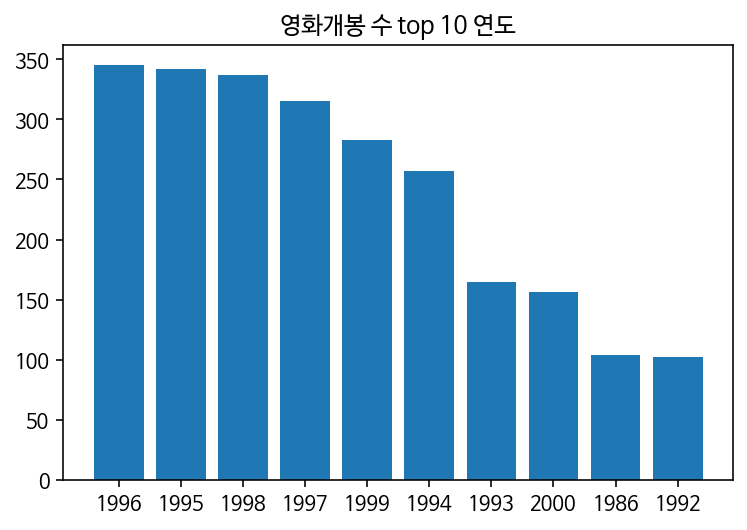

In [12]:
x = top_10_year['year'].tolist()
y = top_10_year['count'].tolist()

plt.bar(x, y)
plt.title("영화개봉 수 top 10 연도")

### 가장 빈번하게 나타난 장르

In [13]:
unique_genre_dict = {}

for index, row in movie_data.iterrows():
    genre_combination = row['genre']
    parsed_genre = genre_combination.split("|")

    for genre in parsed_genre:
        if genre in unique_genre_dict:
            unique_genre_dict[genre] += 1
        else:
            unique_genre_dict[genre] = 1

unique_genre_dict

{'Action': 503,
 'Adventure': 283,
 'Animation': 105,
 "Children's": 251,
 'Comedy': 1200,
 'Crime': 211,
 'Documentary': 127,
 'Drama': 1603,
 'Fantasy': 68,
 'Film-Noir': 44,
 'Horror': 343,
 'Musical': 114,
 'Mystery': 106,
 'Romance': 471,
 'Sci-Fi': 276,
 'Thriller': 492,
 'War': 143,
 'Western': 68}

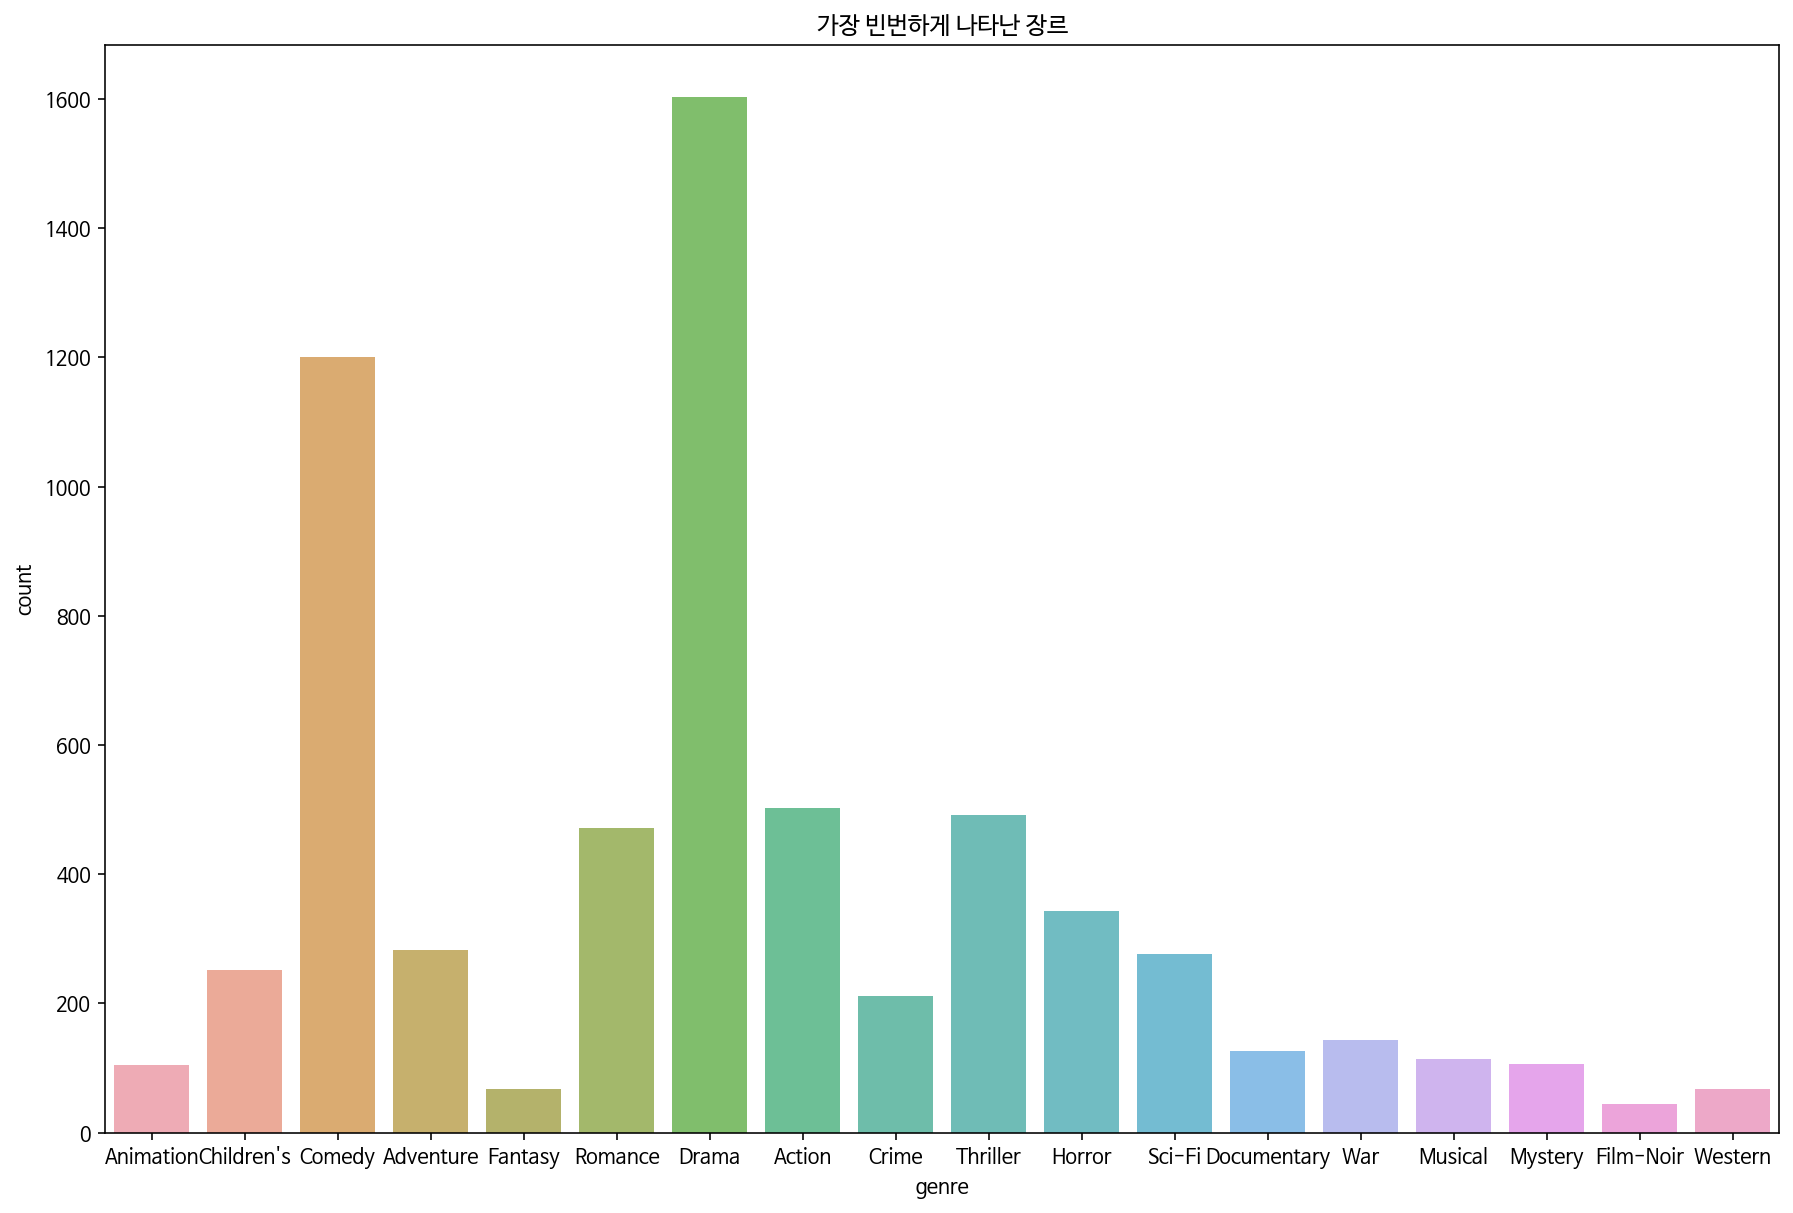

In [14]:
plt.figure(figsize=(15, 10))
sns.barplot(list(unique_genre_dict.keys()), list(unique_genre_dict.values()), alpha=0.8)
plt.title("가장 빈번하게 나타난 장르")
plt.xlabel("genre")
plt.ylabel("count")
plt.show()

## user_data

### 총 유저 수: 6040

In [15]:
len(user_data['user_id'].unique())

6040

### 성별 분포

Text(0.5, 1.0, '유저 성별 분포')

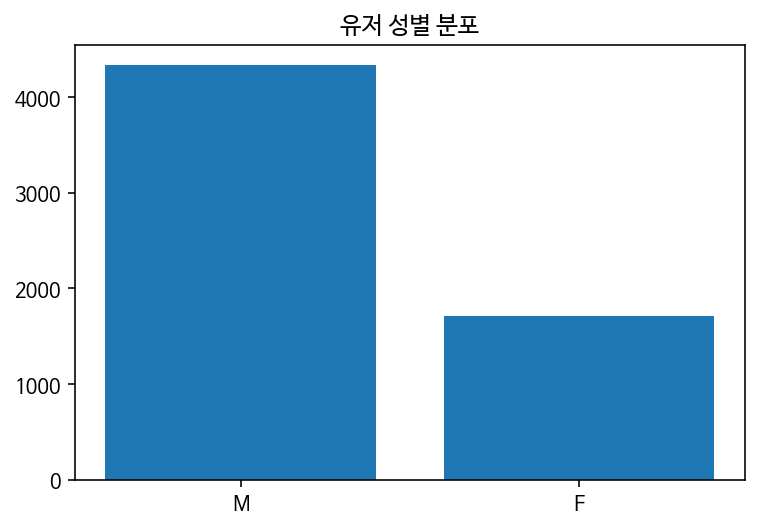

In [16]:
user_gender = user_data['gender'].value_counts()
plt.bar(user_gender.index, user_gender.values)
plt.title("유저 성별 분포")

### 나이 분포

In [17]:
user_data['age'].value_counts()

25    2096
35    1193
18    1103
45     550
50     496
56     380
1      222
Name: age, dtype: int64

In [18]:
user_data.loc[user_data.age == 1, 'age_range'] = 'kids'
user_data.loc[user_data.age == 18, 'age_range'] = 'teens'
user_data.loc[user_data.age == 25, 'age_range'] = '20s'
user_data.loc[user_data.age == 35, 'age_range'] = '30s'
user_data.loc[user_data.age == 45, 'age_range'] = '40s'
user_data.loc[user_data.age == 50, 'age_range'] = '50s'
user_data.loc[user_data.age == 56, 'age_range'] = '50s'

user_data

,user_id,gender,age,occupation,zipcode,age_range
0,1,F,1,10,48067,kids
1,2,M,56,16,70072,50s
2,3,M,25,15,55117,20s
3,4,M,45,7,02460,40s
4,5,M,25,20,55455,20s
...,...,...,...,...,...,...
6035,6036,F,25,15,32603,20s
6036,6037,F,45,1,76006,40s
6037,6038,F,56,1,14706,50s
6038,6039,F,45,0,01060,40s


In [19]:
user_age_range = pd.DataFrame(user_data['age_range'].value_counts())
user_age_range.reset_index(inplace=True)
user_age_range.rename(columns={'index':'range', 'age_range':'counts'}, inplace=True)

In [20]:
user_age_range = pd.DataFrame({'range':['kids', 'teens', '20s', '30s', '40s', '50s'], 
                            'counts':[222, 1103, 2096, 1193, 550, 876]})
user_age_range

,range,counts
0,kids,222
1,teens,1103
2,20s,2096
3,30s,1193
4,40s,550
5,50s,876


Text(0.5, 1.0, '나이 분포')

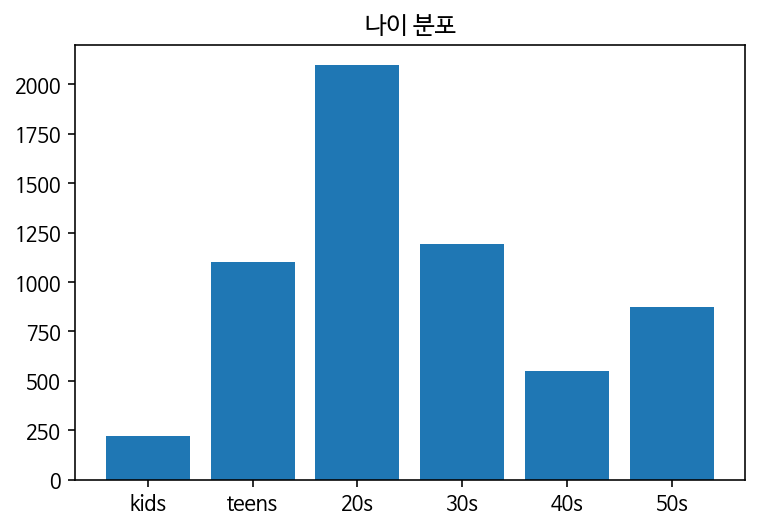

In [21]:
x = user_age_range.range.tolist()
y = user_age_range.counts.tolist()

plt.bar(x, y)
plt.title("나이 분포")

## rating_data

### 각 영화가 평가받은 횟수

In [22]:
rating_count = rating_data['rating'].groupby(rating_data['movie_id']).size()
rating_count

movie_id
1       2077
2        701
3        478
4        170
5        296
        ... 
3948     862
3949     304
3950      54
3951      40
3952     388
Name: rating, Length: 3706, dtype: int64

In [23]:
print("user의 rating기록이 있는 영화 수:", len(rating_data['movie_id'].unique()))
print("\n총 영화 수:", len(movie_data['movie_id'].unique()))

user의 rating기록이 있는 영화 수: 3706

총 영화 수: 3883


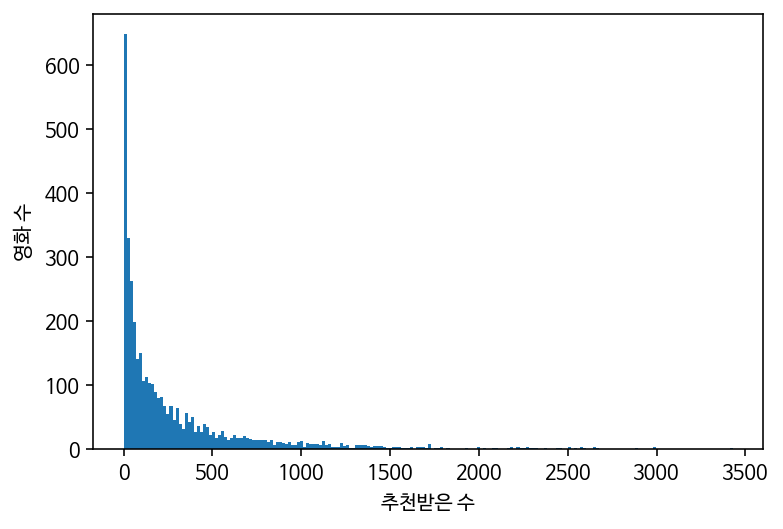

In [24]:
fig1 = plt.hist(rating_count, bins=200)
plt.xlabel("추천받은 수")
plt.ylabel("영화 수")
plt.show()

In [25]:
len(rating_count[rating_count.values < 100])

1687

### 영화의 평균 평점 

In [28]:
rating_data.head(5)

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [37]:
avg_rating = rating_data.groupby('movie_id')['rating'].agg(rated_count='count', rated_mean='mean')
display(avg_rating)

,rated_count,rated_mean
movie_id,,
1,2077,4.146846
2,701,3.201141
3,478,3.016736
4,170,2.729412
5,296,3.006757
...,...,...
3948,862,3.635731
3949,304,4.115132
3950,54,3.666667


count    3706.000000
mean        3.238892
std         0.672925
min         1.000000
25%         2.822705
50%         3.331546
75%         3.740741
max         5.000000
Name: rated_mean, dtype: float64


In [38]:
avg_rating['rated_mean'].describe()

count    3706.000000
mean        3.238892
std         0.672925
min         1.000000
25%         2.822705
50%         3.331546
75%         3.740741
max         5.000000
Name: rated_mean, dtype: float64

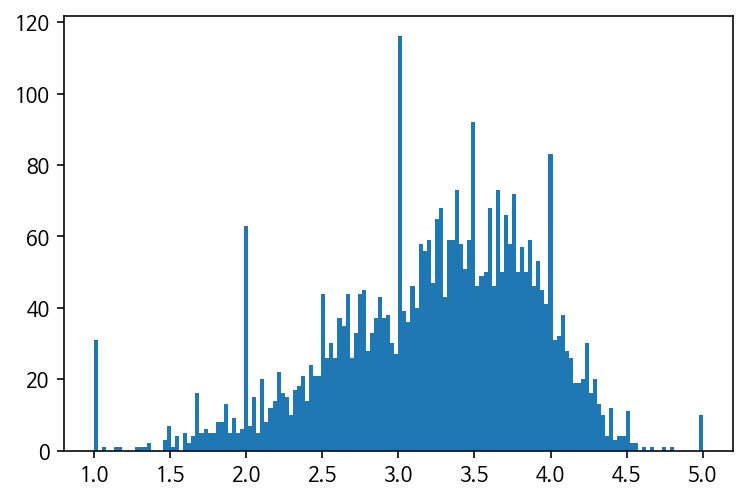

In [35]:
avg_rating['rated_mean'].hist(bins=150, grid=False)